### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)
The scikit-learn version is 0.24.2.


In [4]:
# Now you can import and use OneHotEncoder
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [5]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import workspace_utils

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
df_azdias =  pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f'The Azdias Dataframe has {df_azdias.shape[0]} rows and {df_azdias.shape[1]} columns')
print(f'The Feature Dataframe has {feat_info.shape[0]} rows and {feat_info.shape[1]} columns')

The Azdias Dataframe has 891221 rows and 85 columns
The Feature Dataframe has 85 rows and 4 columns


In [9]:
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [11]:
df_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [12]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [13]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [14]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [15]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [16]:
# Identify missing or unknown data values and convert them to NaNs.
total_na = df_azdias.isna().sum().sum()
print(f'The total number of NaNs values is: {total_na}')

The total number of NaNs values is: 4896838


In [17]:
type(feat_info['missing_or_unknown'][0])

str

In [18]:
#feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

for atrib, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    missing_val = missing.strip('[]').split(',')
    missing_val = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_val]
    if missing_val != ['']:
        df_azdias[atrib] = df_azdias[atrib].replace(missing_val, np.nan)

In [19]:
# Looking is the change is done
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
# Identify missing or unknown data values after the transformations.
total_na = df_azdias.isna().sum().sum()
print(f'The total number of NaNs values is: {total_na}')

The total number of NaNs values is: 8373929


In [21]:
print('Percentage of NaNs of all the dataset: ', np.round(total_na / (df_azdias.shape[0] * df_azdias.shape[1]) * 100,1),'%')

Percentage of NaNs of all the dataset:  11.1 %


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

total_nan = df_azdias.isna().sum()
percengate_nan = np.round(total_nan.values *100/ (df_azdias.shape[0]),2)

dict_nan = {'total': total_nan.values,'percentage': percengate_nan}

df_NaN = pd.DataFrame(data=dict_nan, index=total_nan.index)


In [23]:
df_NaN.sort_values(by='percentage', inplace=True, ascending=False)
df_NaN.head(10)

,total,percentage
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96


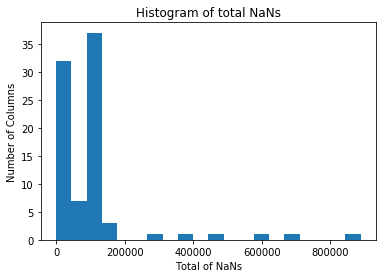

In [24]:
# Histogram using the total sum of NaNs

plt.hist(df_NaN['total'], bins = 20)
plt.title('Histogram of total NaNs')
plt.xlabel('Total of NaNs')
plt.ylabel('Number of Columns')
plt.show()

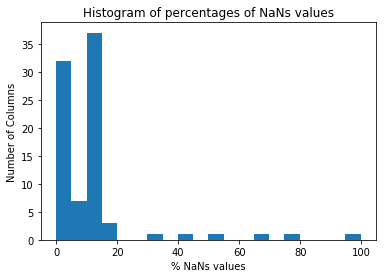

In [25]:
# Histogram using the percentage of NaNs

plt.hist(df_NaN['percentage'], bins = 20)
plt.title('Histogram of percentages of NaNs values')
plt.xlabel('% NaNs values')
plt.ylabel('Number of Columns')
plt.show()

In [26]:
columns_drop = df_NaN[df_NaN['percentage'] > 20].index.tolist()
columns_drop

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

df_azdias.drop(columns_drop, axis=1, inplace=True)

In [28]:
df_azdias.shape

(891221, 79)

In [29]:
# Dropping columns on feature info too
feat_info = feat_info[~feat_info.attribute.isin(columns_drop)]

#### Discussion 1.1.2: Assess Missing Data in Each Column

When performing the histogram I was able to identify that the majority of the columns that contained NaN values were up to the 20% range. So the decision was made to delete the columns that had a percentage greater than this. The columns impacted were the following:

* TITEL_KZ
* AGER_TYP
* KK_KUNDENTYP
* KBA05_BAUMAX
* GEBURTSJAHR
* ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [30]:
df_azdias.shape

(891221, 79)

In [31]:
# How much data is missing in each row of the dataset?
total_null_row = df_azdias.isnull().sum(axis=1)
dict_null_rows = {'total': total_null_row.values, 'percentage': (total_null_row.values / df_azdias.shape[0] * 100)}
df_null_rows = pd.DataFrame(data=dict_null_rows, index=total_null_row.index)

In [32]:
df_null_rows.sort_values(by= 'percentage', inplace =True, ascending=False)
df_null_rows.head()

,total,percentage
732775,49,0.005498
643174,49,0.005498
472919,48,0.005386
345274,47,0.005274
299868,47,0.005274


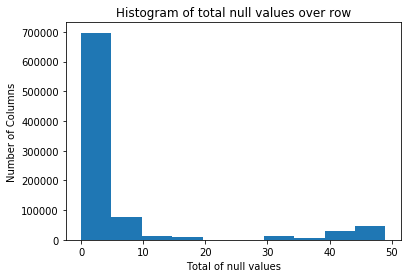

In [33]:
# Histogram of Null values over each row

plt.hist(df_null_rows['total'], bins = 10)
plt.title('Histogram of total null values over row')
plt.xlabel('Total of null values')
plt.ylabel('Number of Columns')
plt.show()

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
number_to_divide = 20
bigger_df_idx = df_null_rows[df_null_rows['total']>= number_to_divide].index
less_df_idx = df_null_rows[df_null_rows['total'] < number_to_divide].index

bigger_df = df_azdias.iloc[bigger_df_idx]
less_df = df_azdias.iloc[less_df_idx]

In [35]:
bigger_df.shape

(94144, 79)

In [36]:
less_df.shape

(797077, 79)

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns = df_NaN.index[-5:].tolist()

In [38]:
def compare_columns(column):
    '''
    Compare two columns plotting a distribution
    Return subplot 1,2 of the two columns of the DataFrame
    '''
    fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(15, 4), sharey=True)

    ax1.set_title(f'Missing values above than {number_to_divide}')
    sns.countplot(bigger_df.loc[:,column] , ax=ax1)

    ax2.set_title(f'Missing values below than {number_to_divide}')
    sns.countplot(less_df.loc[:,column] , ax=ax2)
    plt.show()

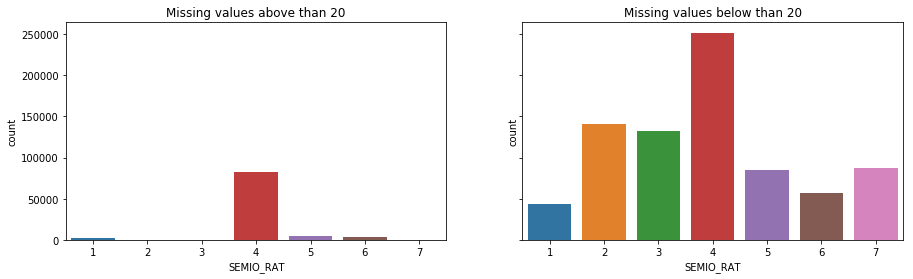

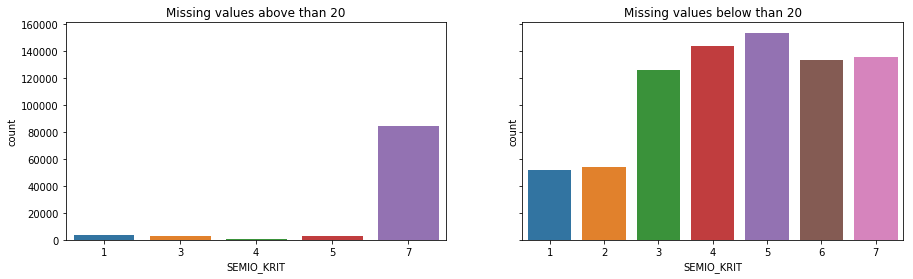

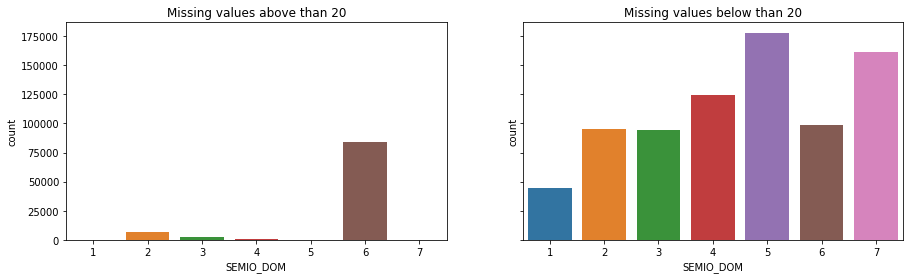

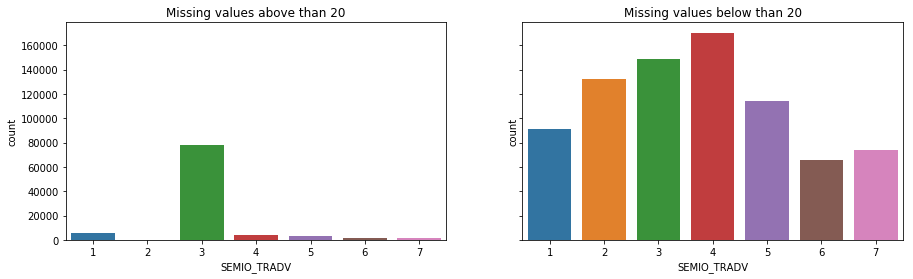

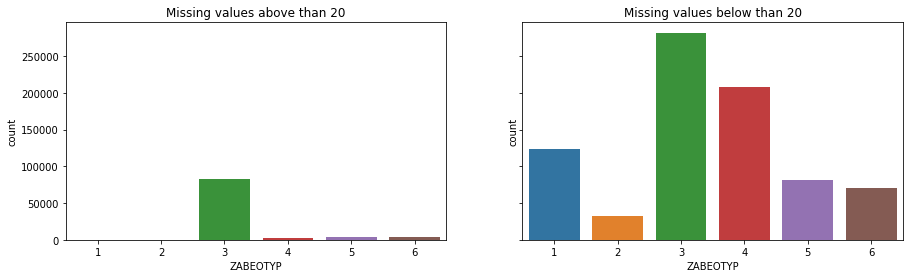

In [39]:
for col in columns:
    compare_columns(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the plots we can conclude that the dataset with missing values greater than 20 behaves very differently from that with values less than 20, so possibly the information contains a bias that could influence the results of the model. In this case, we should do not just drop these values because it could be critical for our process.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [41]:
feat_info.loc[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [42]:
feat_info.loc[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_list = feat_info.loc[feat_info['type'] == 'categorical']['attribute'].tolist()
mixed_list = feat_info.loc[feat_info['type'] == 'mixed']['attribute'].tolist()

mixed_list

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [44]:
less_df['ANREDE_KZ'].nunique()

2

In [45]:
cat_count = less_df[categorical_list].nunique()

In [46]:
binary_num = []
binary_non = []
multi_cate = []
for num_cat, attribute in zip(cat_count, categorical_list):
    if num_cat != 2:
        multi_cate.append(attribute)
    else:
        d_type = less_df[attribute].dtype
        if np.issubdtype(d_type, np.number):
            binary_num.append(attribute)
        else:
            binary_non.append(attribute)

In [47]:
for cate in binary_num:
    print(cate,': ', less_df[cate].nunique())

ANREDE_KZ :  2
GREEN_AVANTGARDE :  2
SOHO_KZ :  2
VERS_TYP :  2


In [48]:
less_df[binary_non].describe()

,OST_WEST_KZ
count,797077
unique,2
top,W
freq,628695


In [49]:
for cate in binary_non:
    print(cate,': ', less_df[cate].nunique())

OST_WEST_KZ :  2


In [50]:
for cate in multi_cate:
    print(cate,': ', less_df[cate].nunique())

CJT_GESAMTTYP :  6
FINANZTYP :  6
GFK_URLAUBERTYP :  12
LP_FAMILIE_FEIN :  11
LP_FAMILIE_GROB :  5
LP_STATUS_FEIN :  10
LP_STATUS_GROB :  5
NATIONALITAET_KZ :  3
SHOPPER_TYP :  4
ZABEOTYP :  6
GEBAEUDETYP :  7
CAMEO_DEUG_2015 :  9
CAMEO_DEU_2015 :  44


In [51]:
# Working with Multicategorical Columns
for cate in multi_cate:
    print(cate,': ')
    print(less_df[cate].value_counts())
    print('\n')

CJT_GESAMTTYP : 
4.0    198089
3.0    147068
2.0    141166
5.0    111032
6.0    101898
1.0     93192
Name: CJT_GESAMTTYP, dtype: int64


FINANZTYP : 
6    289004
1    196805
5    106220
2    104577
4     55874
3     44597
Name: FINANZTYP, dtype: int64


GFK_URLAUBERTYP : 
12.0    129983
10.0    102748
8.0      82992
11.0     75051
5.0      70468
4.0      60413
9.0      57046
3.0      53094
1.0      50640
2.0      43647
7.0      40642
6.0      25721
Name: GFK_URLAUBERTYP, dtype: int64


LP_FAMILIE_FEIN : 
1.0     402248
10.0    128902
2.0      98491
11.0     48727
8.0      21777
7.0      19568
4.0      11573
5.0      11164
9.0      10451
6.0       8512
3.0       4682
Name: LP_FAMILIE_FEIN, dtype: int64


LP_FAMILIE_GROB : 
1.0    402248
5.0    188080
2.0     98491
4.0     49857
3.0     27419
Name: LP_FAMILIE_GROB, dtype: int64


LP_STATUS_FEIN : 
1.0     206766
9.0     136229
10.0    111538
2.0     111016
4.0      73938
3.0      68893
6.0      28870
5.0      27472
8.0      18525
7.0    

In [52]:
less_df.shape

(797077, 79)

In [53]:
multi_cate

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [54]:
less_df.drop(multi_cate, axis=1, inplace=True)
#multi_cate.remove(multi_cate)
less_df.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(797077, 66)

In [55]:
#less_df.drop('CAMEO_DEU_2015', axis=1, inplace=True)
#multi_cate.remove('CAMEO_DEU_2015')
#less_df.shape

In [56]:
# Re-encode categorical variable(s) to be kept in the analysis.
less_df.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [57]:
less_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
746276,3.0,1,4,3,4,2,4,1,0,1.0,9.0,3.0,10.0,3.0,3,6,4,6,7,1,4,5,5,5,2,3,4,4,0.0,1.0,1.0,0.0,3.0,3.0,3.0,2.0,0.0,1.0,2015.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,6.0,2.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,1.0
884754,4.0,1,5,1,5,1,3,1,0,1.0,19.0,5.0,5.0,4.0,3,6,2,6,7,5,3,4,1,3,1,2,4,1,0.0,1.0,2.0,0.0,1.0,6.0,4.0,1.0,0.0,4.0,2015.0,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,4.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0
277633,2.0,1,4,4,1,2,5,1,1,2.0,23.0,6.0,11.0,3.0,7,7,6,7,7,2,1,7,5,1,2,2,5,5,0.0,1.0,1.0,0.0,2.0,1.0,9.0,1.0,0.0,4.0,2008.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,2.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0
506621,2.0,1,2,4,2,2,5,2,0,2.0,2.0,1.0,10.0,5.0,7,7,6,7,7,2,1,7,4,1,2,2,5,5,0.0,1.0,1.0,0.0,4.0,3.0,3.0,19.0,0.0,3.0,1994.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,3.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0,5.0
719161,2.0,2,4,4,1,4,5,1,0,3.0,10.0,3.0,10.0,2.0,2,5,5,7,4,2,5,3,6,7,6,5,5,7,0.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,0.0,5.0,2010.0,0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,6.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0


In [58]:
#less_df = pd.get_dummies(data = less_df, columns=multi_cate)
#less_df.shape

In [59]:
less_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
746276,3.0,1,4,3,4,2,4,1,0,1.0,9.0,3.0,10.0,3.0,3,6,4,6,7,1,4,5,5,5,2,3,4,4,0.0,1.0,1.0,0.0,3.0,3.0,3.0,2.0,0.0,1.0,2015.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,6.0,2.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,1.0
884754,4.0,1,5,1,5,1,3,1,0,1.0,19.0,5.0,5.0,4.0,3,6,2,6,7,5,3,4,1,3,1,2,4,1,0.0,1.0,2.0,0.0,1.0,6.0,4.0,1.0,0.0,4.0,2015.0,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,4.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0
277633,2.0,1,4,4,1,2,5,1,1,2.0,23.0,6.0,11.0,3.0,7,7,6,7,7,2,1,7,5,1,2,2,5,5,0.0,1.0,1.0,0.0,2.0,1.0,9.0,1.0,0.0,4.0,2008.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,2.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0
506621,2.0,1,2,4,2,2,5,2,0,2.0,2.0,1.0,10.0,5.0,7,7,6,7,7,2,1,7,4,1,2,2,5,5,0.0,1.0,1.0,0.0,4.0,3.0,3.0,19.0,0.0,3.0,1994.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,3.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0,5.0
719161,2.0,2,4,4,1,4,5,1,0,3.0,10.0,3.0,10.0,2.0,2,5,5,7,4,2,5,3,6,7,6,5,5,7,0.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,0.0,5.0,2010.0,0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,6.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

In this information the following has been found:
 * Binary numeric: 4 features
 * Non-Numeric Binary: 1 features
 * Multicategorical: 13 features

Regarding non-numeric characteristics, the values have been replaced by 0s and 1s.
Regarding the other multicategorical variables, initially I had decided to only delete the characteristic of **CAMEO_DEU_2015** since it had 44 unique values and could increase the data exponentially. However, moving forward with the project, I had a problem with the PCA as it had too many features, so the decision was made to not take these categorical variables and remove them from the data set.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

We found the following details about this feature in the `Data_Dictionary.md`

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [60]:
less_df['PRAEGENDE_JUGENDJAHRE'].head()

746276    10.0
884754     5.0
277633    11.0
506621    10.0
719161    10.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [61]:
generations = {0: [1,2],
               1: [3,4],
               2: [5,6,7],
               3: [8,9],
               4: [10,11,12,13],
               5: [14,15]}

movements = {0: [1, 3, 5, 8, 10, 12, 14], #Mainstream
             1: [2, 4, 6, 7, 9, 11, 13, 15]} #Avantgarde

In [62]:
# Defining functions for transforming the features
def convert_gen(x):
    for keys, values in generations.items():
        try:
            if x in values:
                return keys
        except:
            return np.nan

def convert_mov(x):
    for keys, values in movements.items():
        try:
            if x in values:
                return keys
        except:
            return np.nan

In [63]:
# Applying functions to both columns
less_df['PRAEGENDE_JUGENDJAHRE_generation'] = less_df['PRAEGENDE_JUGENDJAHRE'].apply(convert_gen)
less_df['PRAEGENDE_JUGENDJAHRE_movements'] = less_df['PRAEGENDE_JUGENDJAHRE'].apply(convert_mov)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
# Dropping column because we do not need it
less_df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [65]:
less_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movements
746276,3.0,1,4,3,4,2,4,1,0,1.0,9.0,3.0,3.0,3,6,4,6,7,1,4,5,5,5,2,3,4,4,0.0,1.0,1.0,0.0,3.0,3.0,3.0,2.0,0.0,1.0,2015.0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,6.0,2.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,1.0,4.0,0.0
884754,4.0,1,5,1,5,1,3,1,0,1.0,19.0,5.0,4.0,3,6,2,6,7,5,3,4,1,3,1,2,4,1,0.0,1.0,2.0,0.0,1.0,6.0,4.0,1.0,0.0,4.0,2015.0,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,4.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,2.0,0.0
277633,2.0,1,4,4,1,2,5,1,1,2.0,23.0,6.0,3.0,7,7,6,7,7,2,1,7,5,1,2,2,5,5,0.0,1.0,1.0,0.0,2.0,1.0,9.0,1.0,0.0,4.0,2008.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,2.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,4.0,1.0
506621,2.0,1,2,4,2,2,5,2,0,2.0,2.0,1.0,5.0,7,7,6,7,7,2,1,7,4,1,2,2,5,5,0.0,1.0,1.0,0.0,4.0,3.0,3.0,19.0,0.0,3.0,1994.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,3.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0,5.0,4.0,0.0
719161,2.0,2,4,4,1,4,5,1,0,3.0,10.0,3.0,2.0,2,5,5,7,4,2,5,3,6,7,6,5,5,7,0.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,0.0,5.0,2010.0,0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,6.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,4.0,0.0


### Investigate "CAMEO_INTL_2015" and engineer two new variables.
We found the following details about this feature in the `Data_Dictionary.md`

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [66]:
less_df['CAMEO_INTL_2015'].tail()

349047    51
349048    33
349049    44
349050    41
891220    43
Name: CAMEO_INTL_2015, dtype: object

In [67]:
# Defining the two other functions for Wealth and Lifestage
def convert_wealth(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])
    except:
        return np.nan

def convert_lifestage(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    except:
        return np.nan

In [68]:
# Applying functions to both columns
less_df['CAMEO_INTL_2015_wealth'] = less_df['CAMEO_INTL_2015'].apply(convert_wealth)
less_df['CAMEO_INTL_2015_lifestage'] = less_df['CAMEO_INTL_2015'].apply(convert_lifestage)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
# Dropping column because we do not need it
less_df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [70]:
less_df.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movements,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
349047,3.0,1,3,3,3,5,1,4,0,3.0,7.0,2.0,5.0,6,6,4,4,7,6,4,5,2,5,2,3,3,4,0.0,2.0,1.0,0.0,6.0,5.0,7.0,12.0,0.0,1.0,1994.0,1,5.0,0.0,0.0,2.0,1.0,1.0,6.0,5.0,6.0,3.0,4.0,2.0,1.0,6.0,340.0,1.0,4.0,2.0,1.0,5.0,3.0,3.0,4.0,4.0,5.0,3.0,0.0,5.0,1.0
349048,4.0,1,4,2,3,3,2,3,0,2.0,19.0,5.0,3.0,3,2,3,1,6,7,3,4,1,3,3,3,4,4,0.0,1.0,2.0,0.0,5.0,5.0,9.0,3.0,0.0,5.0,1992.0,1,7.0,2.0,2.0,0.0,0.0,3.0,6.0,2.0,5.0,5.0,3.0,4.0,3.0,6.0,179.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,3.0,3.0,1.0,4.0,0.0,3.0,3.0
349049,2.0,1,3,2,3,4,1,4,0,2.0,29.0,9.0,1.0,7,7,6,7,7,1,3,7,5,1,4,1,5,5,0.0,1.0,3.0,0.0,5.0,2.0,9.0,7.0,0.0,1.0,1992.0,1,2.0,0.0,3.0,3.0,0.0,2.0,6.0,3.0,5.0,4.0,1.0,4.0,4.0,1.0,135.0,2.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,4.0,2.0,4.0,0.0,4.0,4.0
349050,1.0,1,1,5,2,5,4,5,0,3.0,1.0,1.0,1.0,7,7,7,3,6,2,2,7,4,2,1,2,6,5,0.0,2.0,1.0,0.0,5.0,6.0,9.0,22.0,0.0,2.0,1992.0,1,4.0,0.0,0.0,1.0,1.0,3.0,1.0,5.0,1.0,3.0,3.0,1.0,3.0,2.0,275.0,1.0,2.0,2.0,2.0,5.0,4.0,3.0,4.0,8.0,3.0,5.0,0.0,4.0,1.0
891220,4.0,1,4,2,5,2,1,5,0,2.0,6.0,2.0,1.0,6,6,3,4,6,5,3,6,3,3,3,2,2,2,0.0,1.0,1.0,0.0,5.0,6.0,3.0,10.0,0.0,3.0,1992.0,0,4.0,1.0,3.0,1.0,1.0,2.0,6.0,2.0,8.0,4.0,4.0,3.0,0.0,6.0,728.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0,1.0,0.0,4.0,3.0


In [71]:
mixed_list

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

### Investigate "PLZ8_BAUMAX" and engineer two new variables.

Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

In [72]:
less_df['PLZ8_BAUMAX'].tail()

349047    5.0
349048    1.0
349049    1.0
349050    5.0
891220    1.0
Name: PLZ8_BAUMAX, dtype: float64

In [73]:
family_less_5 = [1,2]
family_more_5 = [3,4,5]

In [74]:
def convert_family_less_5(x):
    if x in family_less_5:
        return 0
    else:
        return 1

def convert_family_more_5(x):
    if x in family_more_5:
        return 0
    else:
        return 1

In [75]:
# Applying functions to both columns
less_df['PLZ8_BAUMAX_family_less_5'] = less_df['PLZ8_BAUMAX'].apply(convert_family_less_5)
less_df['PLZ8_BAUMAX_family_more_5'] = less_df['PLZ8_BAUMAX'].apply(convert_family_more_5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
# Dropping column because we do not need it
less_df.drop('PLZ8_BAUMAX', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.2: Engineer Mixed-Type Features

The information in the data dictionary was reviewed to understand the columns that were referred to, the meaning for each of the values was found in them, so a dictionary was created to be able to apply them to each of the columns and create a new with the openings referred to.

Once the new columns were created, the original columns were deleted so as not to dirty the dataset.

This process was carried out for the following 3 columns (features):

* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015
* PLZ8_BAUMAX

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [77]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
less_df.head(10).T

,746276,884754,277633,506621,719161,813008,509614,63238,179673,851088
ALTERSKATEGORIE_GROB,3.0,4.0,2.0,2.0,2.0,4.0,4.0,3.0,3.0,2.0
ANREDE_KZ,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
FINANZ_MINIMALIST,4.0,5.0,4.0,2.0,4.0,3.0,5.0,5.0,3.0,2.0
FINANZ_SPARER,3.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,4.0,4.0
FINANZ_VORSORGER,4.0,5.0,1.0,2.0,1.0,5.0,4.0,5.0,1.0,1.0
FINANZ_ANLEGER,2.0,1.0,2.0,2.0,4.0,1.0,1.0,1.0,3.0,5.0
FINANZ_UNAUFFAELLIGER,4.0,3.0,5.0,5.0,5.0,3.0,1.0,2.0,3.0,5.0
FINANZ_HAUSBAUER,1.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0
GREEN_AVANTGARDE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HEALTH_TYP,1.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,NaN,2.0


In [78]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [79]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    for atrib, missing in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_val = missing.strip('[]').split(',')
        missing_val = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_val]
        if missing_val != ['']:
            df[atrib] = df[atrib].replace(missing_val, np.nan)
    
    # remove selected columns and rows, ...
    total_nan = df.isna().sum()
    percengate_nan = np.round(total_nan.values *100/ (df.shape[0]),2)
    dict_nan = {'total': total_nan.values,'percentage': percengate_nan}
    df_NaN = pd.DataFrame(data=dict_nan, index=total_nan.index)

    columns_drop = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    
    df.drop(columns_drop, axis=1, inplace=True)
    feat_info = feat_info[~feat_info.attribute.isin(columns_drop)]
    
    total_null_row = df.isnull().sum(axis=1)
    dict_null_rows = {'total': total_null_row.values, 'percentage': (total_null_row.values / df.shape[0] * 100)}
    df_null_rows = pd.DataFrame(data=dict_null_rows, index=total_null_row.index)
    df_null_rows.sort_values(by= 'percentage', inplace =True, ascending=False)
    
    number_to_divide = 20
    bigger_df_idx = df_null_rows[df_null_rows['total']>= number_to_divide].index
    less_df_idx = df_null_rows[df_null_rows['total'] < number_to_divide].index

    bigger_df = df.iloc[bigger_df_idx]
    less_df = df.iloc[less_df_idx]
    
    
    # select, re-encode, and engineer column values.
    #categorical_list = feat_info.loc[feat_info['type'] == 'categorical']['attribute'].tolist()
    #mixed_list = feat_info.loc[feat_info['type'] == 'mixed']['attribute'].tolist()
    multi_cate = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
     
    less_df.drop(multi_cate, axis=1, inplace=True)
     
    # Re-encode categorical variable(s) to be kept in the analysis.
    less_df.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
    #less_df = pd.get_dummies(data = less_df, columns=multi_cate)

    # Applying functions to both columns
    less_df['PRAEGENDE_JUGENDJAHRE_generation'] = less_df['PRAEGENDE_JUGENDJAHRE'].apply(convert_gen)
    less_df['PRAEGENDE_JUGENDJAHRE_movements'] = less_df['PRAEGENDE_JUGENDJAHRE'].apply(convert_mov)
    # Dropping column because we do not need it
    less_df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    # Applying functions to both columns
    less_df['CAMEO_INTL_2015_wealth'] = less_df['CAMEO_INTL_2015'].apply(convert_wealth)
    less_df['CAMEO_INTL_2015_lifestage'] = less_df['CAMEO_INTL_2015'].apply(convert_lifestage)
    # Dropping column because we do not need it
    less_df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # Applying functions to both columns
    less_df['PLZ8_BAUMAX_family_less_5'] = less_df['PLZ8_BAUMAX'].apply(convert_family_less_5)
    less_df['PLZ8_BAUMAX_family_more_5'] = less_df['PLZ8_BAUMAX'].apply(convert_family_more_5)
    # Dropping column because we do not need it
    less_df.drop('PLZ8_BAUMAX', axis=1, inplace=True)

    
    # Return the cleaned dataframe.
    return less_df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [80]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
less_df.isna().sum()

ALTERSKATEGORIE_GROB                 2773
ANREDE_KZ                               0
FINANZ_MINIMALIST                       0
FINANZ_SPARER                           0
FINANZ_VORSORGER                        0
FINANZ_ANLEGER                          0
FINANZ_UNAUFFAELLIGER                   0
FINANZ_HAUSBAUER                        0
GREEN_AVANTGARDE                        0
HEALTH_TYP                          36338
LP_LEBENSPHASE_FEIN                 49487
LP_LEBENSPHASE_GROB                 46679
RETOURTYP_BK_S                       4632
SEMIO_SOZ                               0
SEMIO_FAM                               0
SEMIO_REL                               0
SEMIO_MAT                               0
SEMIO_VERT                              0
SEMIO_LUST                              0
SEMIO_ERL                               0
SEMIO_KULT                              0
SEMIO_RAT                               0
SEMIO_KRIT                              0
SEMIO_DOM                         

In [81]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

In [82]:
less_df_imputer = pd.DataFrame(imputer.fit_transform(less_df), index=less_df.index, columns=less_df.columns)

In [83]:
less_df_imputer.isna().sum()

ALTERSKATEGORIE_GROB                0
ANREDE_KZ                           0
FINANZ_MINIMALIST                   0
FINANZ_SPARER                       0
FINANZ_VORSORGER                    0
FINANZ_ANLEGER                      0
FINANZ_UNAUFFAELLIGER               0
FINANZ_HAUSBAUER                    0
GREEN_AVANTGARDE                    0
HEALTH_TYP                          0
LP_LEBENSPHASE_FEIN                 0
LP_LEBENSPHASE_GROB                 0
RETOURTYP_BK_S                      0
SEMIO_SOZ                           0
SEMIO_FAM                           0
SEMIO_REL                           0
SEMIO_MAT                           0
SEMIO_VERT                          0
SEMIO_LUST                          0
SEMIO_ERL                           0
SEMIO_KULT                          0
SEMIO_RAT                           0
SEMIO_KRIT                          0
SEMIO_DOM                           0
SEMIO_KAEM                          0
SEMIO_PFLICHT                       0
SEMIO_TRADV 

In [84]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [85]:
less_df_scaled = pd.DataFrame(scaler.fit_transform(less_df_imputer),index=less_df_imputer.index, columns=less_df_imputer.columns)

In [86]:
less_df_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movements,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage,PLZ8_BAUMAX_family_less_5,PLZ8_BAUMAX_family_more_5
746276,0.200733,-1.043709,0.683285,0.191366,0.411813,-0.570914,0.959974,-1.502770,-0.530654,-1.633876,-0.512888,-0.479940,-0.310441,-0.587936,0.986080,0.003319,1.104465,1.399902,-1.585320,-0.340642,0.442879,0.669243,0.256661,-1.398609,-0.692860,-0.099385,0.155682,-0.092119,-1.083561,-0.631113,-0.060579,-0.915964,-0.729696,-2.557731,-0.403082,-0.125151,-1.304315,6.622799,-0.517521,-0.541151,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,-0.528617,0.034269,0.715140,-1.883023,0.269793,-1.28177,1.453757,0.776469,2.191824,-0.25669,0.21211,0.403256,-0.935871,-0.616882,-0.337417,-2.175284,-0.127228,-1.526214,0.415815,-0.530654,1.175857,-1.249369,1.584086,0.587936
884754,1.184186,-1.043709,1.409202,-1.155407,1.138052,-1.250019,0.245238,-1.502770,-0.530654,-1.633876,0.293491,0.061016,0.376784,-0.587936,0.986080,-1.043675,1.104465,1.399902,0.316675,-0.888076,-0.067846,-1.750430,-0.879919,-1.946160,-1.228222,-0.099385,-1.543574,-0.092119,-1.083561,0.233692,-0.060579,-2.210438,0.957646,-2.037046,-0.467054,-0.125151,0.630264,6.622799,-0.517521,1.512320,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,-0.528617,-1.129027,-0.270915,1.366950,0.269793,-1.28177,1.453757,0.776469,2.191824,-0.25669,0.21211,0.403256,-0.935871,-0.616882,-0.337417,-2.175284,-1.433035,-1.526214,-0.950157,-0.530654,1.175857,-1.249369,1.584086,0.587936
277633,-0.782720,-1.043709,0.683285,0.864753,-1.766903,-0.570914,1.674710,-1.502770,1.884467,-0.311793,0.616043,0.331494,-0.310441,1.472774,1.508687,1.050312,1.627037,1.399902,-1.109821,-1.982942,1.464328,0.669243,-2.016498,-1.398609,-1.228222,0.439728,0.722101,-0.092119,-1.083561,-0.631113,-0.060579,-1.563201,-1.854591,0.566381,-0.467054,-0.125151,0.630264,4.490554,-0.517521,-2.081254,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,1.303260,1.197564,-1.256970,1.366950,0.269793,-1.28177,1.453757,0.776469,2.191824,-0.25669,0.21211,0.403256,-0.935871,-0.616882,-0.337417,0.830075,0.743311,1.421668,0.415815,1.884467,1.175857,-1.249369,1.584086,0.587936
506621,-0.782720,-1.043709,-0.768547,0.864753,-1.040664,-0.570914,1.674710,-0.792444,-0.530654,-0.311793,-1.077354,-1.020896,1.064009,1.472774,1.508687,1.050312,1.627037,1.399902,-1.109821,-1.982942,1.464328,0.064325,-2.016498,-1.398609,-1.228222,0.439728,0.722101,-0.092119,-1.083561,-0.631113,-0.060579,-0.268726,-0.729696,-2.557731,0.684448,-0.125151,-0.014596,0.226064,-0.517521,-2.081254,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,-1.444556,1.197564,-0.763943,0.283625,0.269793,-1.28177,0.810428,0.776469,2.191824,-0.25669,0.21211,0.403256,-0.935871,-0.616882,-0.337417,-0.171711,1.613849,1.421668,0.415815,-0.530654,1.175857,-1.249369,1.584086,0.587936
719161,-0.782720,0.958121,0.683285,0.864753,-1.766903,0.787296,1.674710,-1.502770,-0.530654,1.010291,-0.432250,-0.479940,-0.997667,-1.103113,0.463473,0.526815,1.627037,-0.142659,-1.109821,0.206791,-0.578571,1.274161,1.393241,0.791598,0.377866,0.439728,1.854938,-0.092119,-1.083561,-0.631113,-0.060579,-0.915964,-0.729696,-3.078416,-0.467054,-0.125151,1.275123,5.099767,-0.517521,2.

### Discussion 2.1: Apply Feature Scaling

First, it was reviewed how many NaN values were in the dataset, then it used the SimpleImputer since it could not access the Imputer, it was decided to use 'most_frequent' strategy so that the information can follow the trend and not generate any bias.

Once finished working with the NaNs values, the StandardScaler was applied to each of the data in the dataset and a new dataset_scaled was generated which already has the information ready to be worked on.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [87]:
# Apply PCA to the data.
# First we want to know hoy many features we have
less_df_scaled.shape[1]

69

In [88]:
from sklearn.decomposition import PCA

In [89]:
pca = PCA()
less_df_pca = pca.fit_transform(less_df_scaled)

In [90]:
# Investigate the variance accounted for by each principal component.
def plot_pca(pca):
    
    n_components = np.arange(len(pca.explained_variance_ratio_))
    acum_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(13,5))
    plt.bar(n_components, pca.explained_variance_ratio_)
    plt.plot(acum_ratio)
    plt.title('Explained Variance Per Principal Component')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained (%)')
    plt.show()

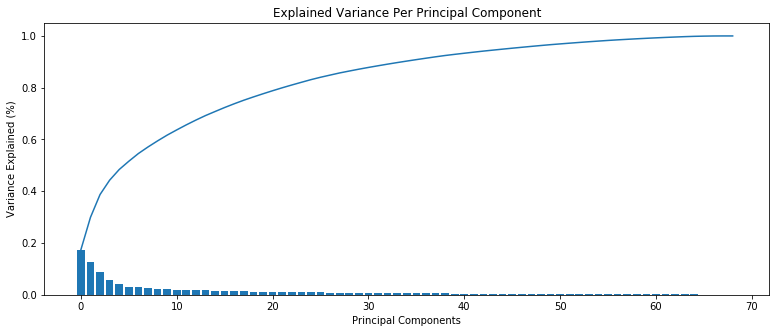

In [91]:
plot_pca(pca)

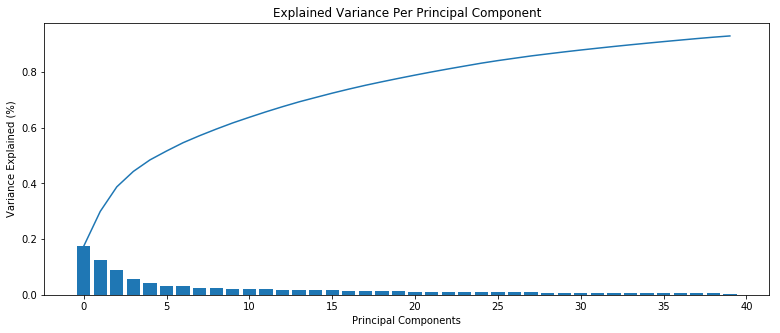

In [92]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=40)
less_df_pca = pca.fit_transform(less_df_scaled)
plot_pca(pca)

In [93]:
pca.explained_variance_ratio_.sum()

0.9288423934091224

### Discussion 2.2: Perform Dimensionality Reduction

After performing the PCA on the dataset and analyzing the explained variance ratio, it was concluded that with 40 features we could cover a large percentage of the variance. Therefore, it was later decided to perform another PCA with 40 components and it gave us an explained variance ratio of 93%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [94]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_weights(pca, component):
    result = pd.DataFrame(pca.components_, columns=list(less_df_scaled.columns))
    weights = result.iloc[component].sort_values(ascending=False)
    return weights

In [95]:
print(get_weights(pca,0).head(),"\n\n",get_weights(pca,0).tail())

PLZ8_ANTG3                   0.225184
PLZ8_ANTG4                   0.216865
PLZ8_BAUMAX_family_less_5    0.204863
CAMEO_INTL_2015_wealth       0.196544
ORTSGR_KLS9                  0.194966
Name: 0, dtype: float64 

 KBA05_ANTG1                 -0.205425
KBA05_GBZ                   -0.208293
PLZ8_BAUMAX_family_more_5   -0.211841
MOBI_REGIO                  -0.216273
PLZ8_ANTG1                  -0.224893
Name: 0, dtype: float64


In [96]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(get_weights(pca,1).head(),"\n\n",get_weights(pca,1).tail())

ALTERSKATEGORIE_GROB    0.273180
FINANZ_VORSORGER        0.245482
SEMIO_ERL               0.236387
SEMIO_LUST              0.190205
RETOURTYP_BK_S          0.163598
Name: 1, dtype: float64 

 SEMIO_TRADV                        -0.240296
SEMIO_PFLICHT                      -0.242472
PRAEGENDE_JUGENDJAHRE_generation   -0.253980
FINANZ_SPARER                      -0.254109
SEMIO_REL                          -0.267726
Name: 1, dtype: float64


In [97]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(get_weights(pca,2).head(),"\n\n",get_weights(pca,2).tail())

SEMIO_VERT           0.346961
SEMIO_SOZ            0.262144
SEMIO_FAM            0.248878
SEMIO_KULT           0.235227
FINANZ_MINIMALIST    0.163111
Name: 2, dtype: float64 

 SEMIO_RAT    -0.215899
SEMIO_KRIT   -0.277538
SEMIO_DOM    -0.312980
SEMIO_KAEM   -0.337236
ANREDE_KZ    -0.368126
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

#### 1st Principal Components

Highs:
* PLZ8_ANTG3 -> 0.225184 | Refering to Number of 6-10 family houses in the PLZ8 region
* PLZ8_ANTG4 -> 0.216865 | Number of 10+ family houses in the PLZ8 region
* PLZ8_BAUMAX_family_less_5 ->0.204863 | Feature created referring to a number of less than 5 people in the family in PLZ8 region

Lowers:
* PLZ8_BAUMAX_family_more_5 -> -0.211841 | Feature created referring to a number of more than 5 people in the family in PLZ8 region
* MOBI_REGIO -> -0.216273 | Movement patterns
* PLZ8_ANTG1 -> -0.224893 | Number of 1-2 family houses in the PLZ8 region

#### 2nd Principal Components

Highs:
* ALTERSKATEGORIE_GROB -> 0.273180 | Estimated age based on given name analysis
* FINANZ_VORSORGER -> 0.245482 | Financial Prepared level
* SEMIO_ERL -> 0.236387 | Event Oriented Personality level

Lowers:
* PRAEGENDE_JUGENDJAHRE_generation ->-0.253980 | Generation range between 40's and 90's
* FINANZ_SPARER -> -0.254109 | Financial money-saver level
* SEMIO_REL -> -0.267726 | Religious personality level

#### 3rd Principal Components

Highs:
* SEMIO_VERT -> 0.346961 | Dreamful personality level
* SEMIO_SOZ -> 0.262144 | socially-minded personality level
* SEMIO_FAM -> 0.248878 | family-minded personality level

Lowers:
* SEMIO_DOM -> -0.312980 | dominant-minded personality level
* SEMIO_KAEM -> -0.337236 | combative attitude personality level
* ANREDE_KZ -> -0.368126 | gender


#### With this information we can conclude the following:
- First Components are related to family houses specially in the PLZ8 region
- Second Components are related basically on Financial levels and age range
- Third Components are related to Personality types levels

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [98]:
less_df_pca.shape[1]

40

In [99]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts...
# run k-means clustering on the data and...        
# compute the average within-cluster distances.

def get_score(df, centers):
    kmeans = KMeans(n_clusters=centers)
    model = kmeans.fit(less_df_pca)
    score = np.abs(model.score(less_df_pca))
    
    return score

In [100]:
scores = []
list_centers = list(range(1,20))
for center in list_centers:
    scores.append(get_score(less_df_pca,center))

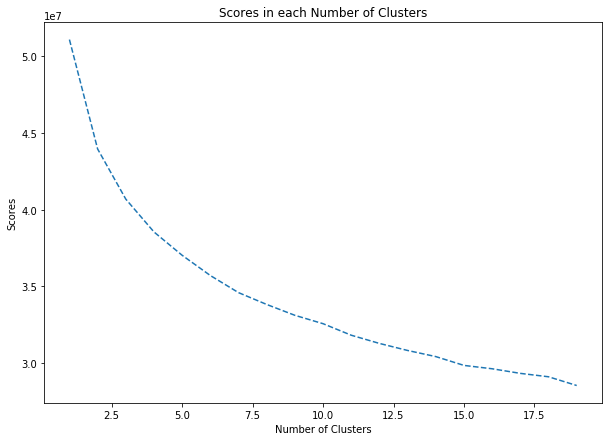

In [101]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10,7))
plt.plot(list_centers,scores,linestyle = '--')
plt.title('Scores in each Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Scores')
plt.show()

In [102]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=15)
model = kmeans.fit(less_df_pca)
predictions = model.predict(less_df_pca)

### Discussion 3.1: Apply Clustering to General Population

We created a function to get the scores from clusters between 1 and 20. Then we had to plot the scores and the number of clusters to find the best number of clusters that could fit in our solution.

In my opinion we should choose a cluster between [13,15]. So I choose 15 Clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [103]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [104]:
customers.shape

(191652, 85)

In [105]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [106]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_new = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_lau

In [107]:
customer_new.shape

(141590, 69)

In [108]:
customer_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movements,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage,PLZ8_BAUMAX_family_less_5,PLZ8_BAUMAX_family_more_5
12933,3.0,2,3,1,5,2,2,3,0,2.0,8.0,2.0,3.0,4,1,1,2,4,1,6,1,4,7,6,7,4,3,0.0,2.0,1.0,0.0,4.0,6.0,3.0,13.0,0.0,5.0,2012.0,0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,1.0,0.0,NaN,NaN,1,1
57873,4.0,1,5,1,5,1,3,1,0,1.0,NaN,NaN,NaN,3,6,2,6,7,5,3,4,1,3,4,2,4,1,0.0,1.0,2.0,0.0,2.0,6.0,8.0,1.0,0.0,4.0,2007.0,0,0.0,NaN,NaN,NaN,NaN,NaN,7.0,1.0,7.0,5.0,NaN,NaN,NaN,NaN,985.0,3.0,2.0,0.0,0.0,4.0,5.0,2.0,1.0,1.0,NaN,NaN,2.0,3.0,0,1
34910,4.0,1,3,2,4,2,3,1,0,1.0,37.0,12.0,5.0,3,6,2,6,7,5,3,4,1,3,3,2,4,1,0.0,1.0,3.0,0.0,4.0,3.0,4.0,8.0,0.0,1.0,2014.0,0,4.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,4.0,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,3.0,3.0,0.0,NaN,NaN,1,1
374,3.0,1,3,2,4,2,3,1,0,1.0,24.0,7.0,5.0,3,4,4,6,7,4,4,5,5,3,2,3,4,4,0.0,1.0,4.0,0.0,4.0,2.0,3.0,6.0,0.0,2.0,2015.0,0,3.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,3.0,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,5.0,3.0,0.0,NaN,NaN,1,1
11068,4.0,1,4,1,5,1,2,2,0,1.0,38.0,12.0,5.0,3,6,2,6,7,5,3,4,1,1,3,2,4,1,0.0,1.0,2.0,0.0,4.0,3.0,3.0,11.0,0.0,3.0,2014.0,0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,6.0,3.0,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,3.0,2.0,0.0,NaN,NaN,1,1


In [109]:
# Using the Imputer
customer_imputed = pd.DataFrame(imputer.transform(customer_new), index=customer_new.index, columns=customer_new.columns)

In [110]:
# Using Scaler
customer_scaled = pd.DataFrame(scaler.transform(customer_imputed),index=customer_imputed.index, columns=customer_imputed.columns)
customer_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movements,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage,PLZ8_BAUMAX_family_less_5,PLZ8_BAUMAX_family_more_5
12933,0.200733,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,-0.082119,-0.530654,-0.311793,-0.593526,-0.750418,-0.310441,-0.072758,-1.626956,-1.567172,-0.985825,-0.142659,-1.585320,0.754224,-1.600021,0.064325,1.393241,0.791598,1.448591,-0.099385,-0.410737,-0.092119,0.922883,-0.631113,-0.060579,-0.268726,0.957646,-2.557731,0.300614,-0.125151,1.275123,5.708979,-0.517521,-2.081254,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,-0.070648,0.034269,0.222112,0.283625,0.269793,-1.28177,0.167099,0.776469,2.191824,-0.256690,0.212110,0.403256,-0.935871,-0.616882,-0.337417,-0.171711,-0.997766,-0.052273,-1.633144,-0.530654,1.175857,-1.249369,1.584086,0.587936
57873,1.184186,-1.043709,1.409202,-1.155407,1.138052,-1.250019,0.245238,-1.502770,-0.530654,-1.633876,-1.157992,-0.750418,1.064009,-0.587936,0.986080,-1.043675,1.104465,1.399902,0.316675,-0.888076,-0.067846,-1.750430,-0.879919,-0.303505,-1.228222,-0.099385,-1.543574,-0.092119,-1.083561,0.233692,-0.060579,-1.563201,0.957646,0.045696,-0.467054,-0.125151,0.630264,4.185947,-0.517521,-2.081254,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,1.303260,-1.710675,1.208168,1.366950,0.269793,-1.28177,0.810428,0.776469,1.008256,0.785871,-0.889352,-1.647867,-0.935871,0.418829,1.484596,-1.173497,-1.868305,-1.526214,1.098802,-0.530654,-0.869590,0.094671,-0.631279,0.587936
34910,1.184186,-1.043709,-0.042631,-0.482020,0.411813,-0.570914,0.245238,-1.502770,-0.530654,-1.633876,1.744974,1.954362,1.064009,-0.587936,0.986080,-1.043675,1.104465,1.399902,0.316675,-0.888076,-0.067846,-1.750430,-0.879919,-0.851057,-1.228222,-0.099385,-1.543574,-0.092119,-1.083561,1.098497,-0.060579,-0.268726,-0.729696,-2.037046,-0.019248,-0.125151,-1.304315,6.318192,-0.517521,-0.027783,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,0.387321,0.034269,-0.270915,-0.799699,0.269793,-1.28177,1.453757,0.776469,2.191824,-0.256690,0.212110,0.403256,-0.935871,-0.616882,-0.337417,-1.173497,-0.562497,-0.052273,-0.267171,-0.530654,1.175857,-1.249369,1.584086,0.587936
374,0.200733,-1.043709,-0.042631,-0.482020,0.411813,-0.570914,0.245238,-1.502770,-0.530654,-1.633876,0.696681,0.601972,1.064009,-0.587936,-0.059134,0.003319,1.104465,1.399902,-0.158824,-0.340642,0.442879,0.669243,-0.879919,-1.398609,-0.692860,-0.099385,0.155682,-0.092119,-1.083561,1.963302,-0.060579,-0.268726,-1.292143,-2.557731,-0.147192,-0.125151,-0.659455,6.622799,-0.517521,-0.541151,-1.010076,-0.96683,-0.595372,-0.464432,-0.116246,-0.070648,0.615916,-0.763943,-0.799699,0.269793,-1.28177,0.810428,0.776469,2.191824,-0.256690,0.212110,0.403256,-0.935871,-0.616882,-0.337417,0.830075,0.743311,1.421668,-0.267171,-0.530654,1.175857,-1.249369,1.584086,0.587936
11068,1.184186,-1.043709,0.683285,-1.155407,1.138052,-1.250019,-0.469499,-0.792444,-0.530654,-1.633876,1.825612,1.954362,1.064009,-0.587936,0.986080,-1.043675,1.104465,1.399902,0.316675,-0.888076,-0.067846,-1.750430,-2.016498,-0.851057,-1.228222,-0.099385,-1.543574,-0.092119,-1.083561,0.233692,-0.060579,-0.268726,-0.729696,-2.557731,0.172669,-0.125151,-0.014596,6.

In [111]:
# Applying PCA to the customer dataset
customer_pca = pca.transform(customer_scaled)

In [112]:
customer_pca.shape

(141590, 40)

In [113]:
# Applying the Kmeans to the customer_pca
customer_predictions = model.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

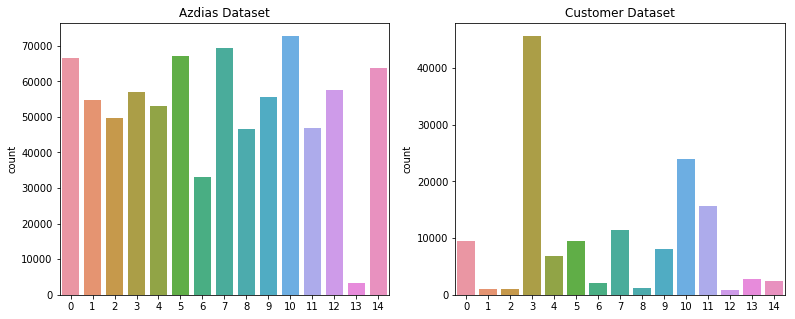

In [114]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5))
sns.countplot(predictions, ax=ax1)
ax1.set_title('Azdias Dataset')
sns.countplot(customer_predictions, ax=ax2)
ax2.set_title('Customer Dataset')
plt.show()

In [147]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# overrepresented
cluster_center14 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[14]))

In [148]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# underrepresented
cluster_center3 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[3]))

In [157]:
over_df = pd.DataFrame(data=cluster_center14, index=customer_new.columns, columns=['Cluster_Centers'])
over_df.sort_values(ascending=False, by='Cluster_Centers').head()

,Cluster_Centers
MIN_GEBAEUDEJAHR,1994.291910
KBA13_ANZAHL_PKW,717.501702
LP_LEBENSPHASE_FEIN,17.533620
WOHNDAUER_2008,7.510208
SEMIO_KULT,6.856658


In [158]:
under_df = pd.DataFrame(data=cluster_center3, index=customer_new.columns, columns=['Cluster_Centers'])
under_df.sort_values(ascending=False, by='Cluster_Centers').head()

,Cluster_Centers
MIN_GEBAEUDEJAHR,1992.965083
KBA13_ANZAHL_PKW,700.050033
LP_LEBENSPHASE_FEIN,24.037447
WOHNDAUER_2008,8.495754
LP_LEBENSPHASE_GROB,7.010992


### Discussion 3.3: Compare Customer Data to Demographics Data

Regarding what was developed, when comparing the proportion of the customer data and the general data we found certain differences, which consider that they may have arisen at the moment in which he decided to drop the multicategorical features, perhaps by applying get_dummies it could have obtained a more accurate result.

My findings:

According to what can be seen, cluster 14 is a cluster that is overrepresented in the general data and has a greater impact than it means for the customer base. Evaluating the characteristics we have the following:

* **MIN_GEBAEUDEJAHR:** The people who are in this cluster have the first year of construction as 1994
* **KBA13_ANZAHL_PKW:** The number of cars in the PLZ8 region is approximately 718
* **LP_LEBENSPHASE_FEIN:** People in this group fall between independent couples and wealthy homeowner couples of younger age.

Our suggestions should be that this group of people should not be our target.

Furthermore, cluster 3 is underrepresented. This means that this group of people could be a potential target. The features are as follows:
* **MIN_GEBAEUDEJAHR:** The people who are in this cluster have the first year of construction as 1993
* **KBA13_ANZAHL_PKW:** The number of cars in the PLZ8 region is approximately 700
* **LP_LEBENSPHASE_FEIN:** People in this group fall between low-income families and average-income families.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.